# Sequence with Local Adressability

In [1]:
import numpy as np

from dataclasses import replace
from matplotlib import pyplot as plt

import pulser
import pulser_simulation

The `Sequence` and its core elements were introduced in the introductive tutorial on `Sequence` creation. In a second notebook, we introduced the interaction between the atoms, and discussed the **Rydberg blockade** an effect that induces that two atoms placed close to each other can't be both in the Rydberg state.

All the `Sequence` so far only used the `Rydberg.Global` channel. There are many useful applications to a `Device` having only such a channel (like the `pulser.AnalogDevice`) such as the preparation of an anti-ferromagnetic state (AFM), solving an MIS, ... This way of programming only one `Rydberg.Global` channel is named **Analog** Quantum Computating.

However, to enable more use-cases, you usually want to have access to the states of the qubits locally. This is notably the case in **Digital-Analog** Quantum Computing, where you want to combine global addressing and some local operations, as well as in **Digital** Quantum Computing, where a widely-used interface is to program using gates. The `Device` `pulser.DigitalAnalogDevice` is an example of a `Device` that can be used for **Digital-Analog** and **Digital** Quantum Computing.

In our platform, **Digital** Quantum Computing is implemented via the `Raman` channels, and is presented in the next notebook. We will here combine `Rydberg.Global` and channels addressing the ground-rydberg transition locally to perform **Digital-Analog** Quantum Computing.

There are two channels that addresses the ground-rydberg transistion of each atom locally:
- The `Rydberg.Local` channel, that works like a `Rydberg.Global` channel but needs a list of atoms to target. It is easy to program and understand, but should mainly be considered for simulation only.
- The `DMM` channel, for **Detuning Map Modulator**, that only modifies the local detuning experienced by each atom. It involves more concepts, but is closer to the physical implementation.

Let's investigate the effect of **Rydberg Blockade** using these two channels. We will keep the same `Register` as with the Analog experiment, and prepare them in the $\left|rg\right>$ state, before applying a $\pi$-pulse on the second atom.

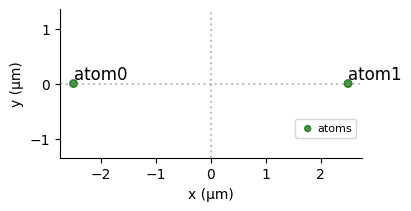

In [2]:
reg = pulser.Register.rectangle(1, 2, spacing=5, prefix="atom")
reg.draw()
pi_wvf = pulser.BlackmanWaveform(600, np.pi)
pi_pulse = pulser.Pulse.ConstantDetuning(pi_wvf, 0.0, 0.0)

## The `Rydberg.Local` channel

The `Rydberg.Local` channel implements a Hamiltonian composed of some local terms in the Drive Hamiltonian and the same interaction Hamiltonian as for the `Rydberg.Global` channel:
$$ H(t) = H_{int} + \sum_{j\in \{targeted\ atoms\}} {H^D}^{(j)}$$

The targeted atoms can be defined at channel declaration:

In [3]:
local_seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)
print(
    "Available channels before declaration of rydberg_local:",
    list(local_seq.available_channels.keys()),
)
local_seq.declare_channel(
    "rydberg_local", "rydberg_local", initial_target="atom0"
)
# After declaration, the "rydberg_local" channel is no-longer available
print(
    "Available channels after declaration of rydberg_local:",
    list(local_seq.available_channels.keys()),
)

Available channels before declaration of rydberg_local: ['rydberg_global', 'rydberg_local', 'raman_local', 'dmm_0']
Available channels after declaration of rydberg_local: ['rydberg_global', 'raman_local', 'dmm_0']


Or it can be done through the standard `target` instruction:

In [4]:
local_seq.target("atom0", "rydberg_local")

Event though target declaration when declaring the channel is optional, associating a target to the channel is mandatory before adding any `Pulse` to it. Note: For `Global` channels this is predefined to be all qubits in the device. If the channel allows it, a set of qubits can be provided as target (the `Rydberg.Local` channel of `DigitalAnalogDevice` only allows to target 1 qubit).

We are targeting the atom `atom0`: we can excite it to the Rydberg state by applying a $\pi$-pulse. The state of the second atom will not be modified since it does not receive any light.

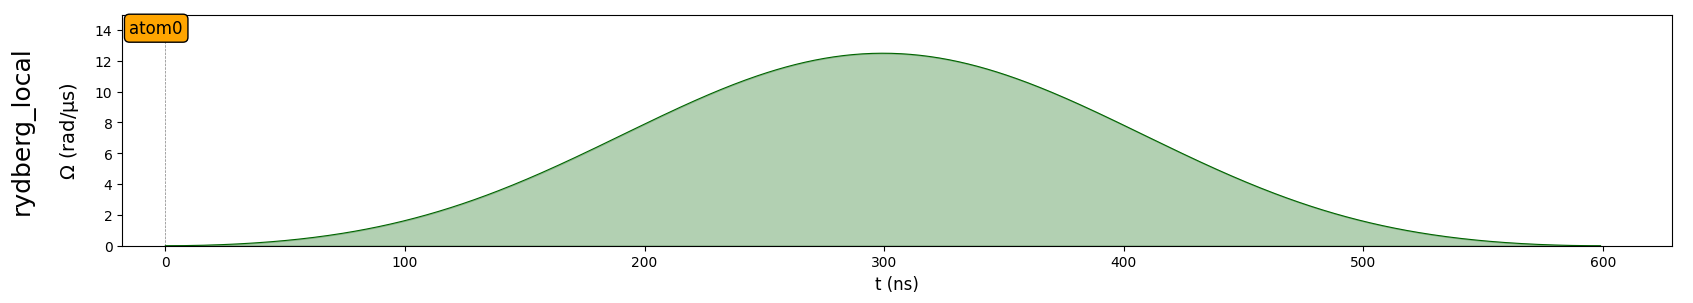

In [5]:
local_seq.add(pi_pulse, "rydberg_local")
local_seq.draw()

The prepared state is $\left| rg\right> = (1, 0) \otimes (0, 1) = (0, 1, 0, 0)$ (see the convention page for details):

In [6]:
# Measuring the state in |rg>
sim = pulser_simulation.QutipBackend(local_seq)
res = sim.run()
res.get_final_state()

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.+0.00000000e+00j]
 [1.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.-1.03500888e-06j]]

Let's now apply a $\pi$-pulse on the second atom only, to try to make it reach the Rydberg state as well 

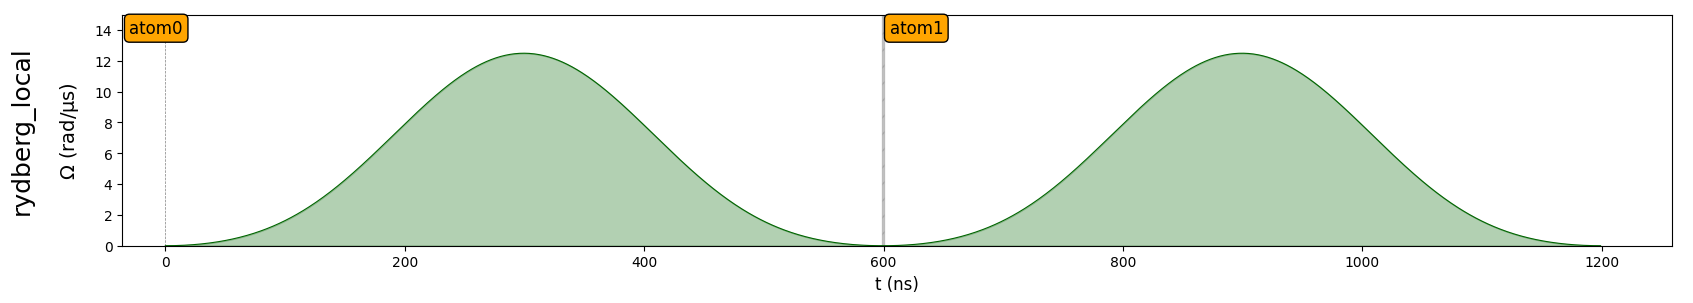

In [7]:
local_seq.target("atom1", "rydberg_local")  # changing the targeted atom
local_seq.add(pi_pulse, "rydberg_local")
local_seq.draw()

In [8]:
sim = pulser_simulation.QutipBackend(local_seq)
res = sim.run()
res.get_final_state()

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 1.06153885e-06-1.87760060e-07j]
 [ 1.00000000e+00+0.00000000e+00j]
 [-1.03523809e-06+2.12339460e-08j]
 [ 0.00000000e+00-5.38620822e-12j]]

The system is still in the $\left| rg\right>$ state: the fact that `atom0` was first excited to the Rydberg state prevents `atom1` from being excited to the same state with the same pulse, i.e. `atom0` **blockades the excitation of** `atom1` to the Rydberg state.

This conditional excitation of one atom depending on the state of another closely resembles that of a controlled gate in a quantum circuit. In fact, for neutral atom devices, the **Rydberg blockade mechanism is the key behind entanglement generation between atoms**.

## The `DMM` Channel 

The **Detuning Map Modulator** or `DMM` is a `Channel` that applies a `Global` pulse of **zero amplitude** and **negative detuning** on a `DetuningMap`. The `DetuningMap` consists of a set of weights on specific sites that dictate the proportion of detuning applied by the `DMM` each site receives.

This modulation of the `DetuningMap` by the `DMM` Channel is equivalent to adding a term $-\frac{\hbar}{2}\sum_{i}\epsilon_{i}\Delta(t)\sigma^{z}_{i}$ to the Ising Hamiltonian. Here, $\Delta(t)$ is the detuning applied on the `DMM`, and $(\epsilon_i)_{i}$ are the weights defined in the `DetuningMap` for each atom.

We have here only two atoms, so we only need to assign a non-nul weight to 1 atom to have local addressability.

### Define a Detuning Map

A `DetuningMap` associates a set of locations with a set of weights. The locations are the trap coordinates to address and the weights $(\epsilon_i)_i$ have to be between 0 and 1.

A `DetuningMap` can be defined from a `RegisterLayout`, a `Register` or a `MappableRegister` by using the `define_detuning_map` method. All it takes is a mapping between trap/qubit IDs and weights.

An extensive presentation of this feature is provided in an [advanced tutorial](https://pulser.readthedocs.io/en/stable/tutorials/dmm.html). Let's define it here from the `Register`, since it's the object we are manipulating. Let's associate a weight of 1 to `atom0`, and a nul weight to `atom1`, such that we have local control over the detuning of `atom0` but not over `atom1`.

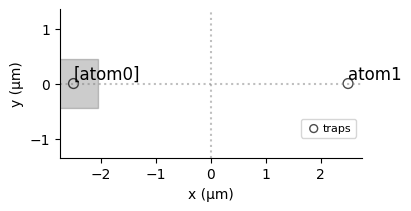

In [9]:
# Mapping each qubit id to a weight
detuning_map = reg.define_detuning_map({"atom0": 1.0, "atom1": 0.0})

detuning_map.draw(labels=["atom0", "atom1"])

The traps are represented by a grey dot and highlighted by a grey square, whose shade is proportional to the value of the associated weight. If the weight is null then no `DMM` is applied: the atom is not highlighted by a grey square.

### `DMM` configuration

`DMM` does not appear in the `Device.channels`, but in the `Device.dmm_channels` property:

In [10]:
pulser.DigitalAnalogDevice.dmm_channels

{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

In a `Sequence`, the `DMM` channels can be configured using `config_detuning_map`. This configuration associates a `DMM`, referenced by its `dmm_id` in the `Device`, with a `DetuningMap`. It automatically generates a `dmm_name` in the `Sequence` from the `dmm_id` (see the [advanced tutorial](https://pulser.readthedocs.io/en/stable/tutorials/dmm.html) for more information):

In [11]:
dmm_seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)
dmm_seq.config_detuning_map(detuning_map, "dmm_0")
print(dmm_seq.declared_channels)

{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}


### Preparing a $\left|rg\right>$ state

Applying only a local detuning does not modify the state of the atom from a measurement point of view (it only modifies its phase, but not the probability to measure each state). The `DMM` is then used along with a `Rydberg.Global` Channel:

In [12]:
dmm_seq.declare_channel("rydberg_global", "rydberg_global")

 The Hamiltonian implemented by the combination of a Pulse $(\Omega, \delta, \phi)$ applied on `Rydberg.Global` and a detuning $\delta_{DMM}$ applied on `dmm_0` is:

$$H = \frac{\hbar \Omega(t)}{2} \sigma_1^x + \frac{\hbar}{2}(\delta(t)-|\delta_{DMM}(t)|) n_1 + \frac{\hbar \Omega(t)}{2} \sigma_2^x + \frac{\hbar \delta(t)}{2} n_2+ \frac{C_6}{R^6} n_1n_2 $$

Since we only want to perform a $\pi$-pulse on the first qubit `atom0`, we have the condition $\delta(t)=|\delta_{DMM}|(t)$.
This means that the second qubit `atom1` will see a `Pulse` of amplitude $\Omega$ and detuning $\delta\ge 0$, which is a different situation than in the case of `Rydberg.Local` presented above. If $\delta \gg 0$, then the qubit receives a light whose frequency is very far from the frequency of the transition: the qubit interacts very little with such a light. 

Let's then add a Pulse on a `Rydberg.Global` channel whose amplitude is a waveform of area $\pi$, and whose detuning is very far from 0, but can still be matched by the detuning applied on the `DMM`.

Max detuning the DMM can take: 125.66370614359172
Max detuning the Rydberg.Global channel can take: 125.66370614359172
Detuning is taken as constant, equal to: 125.66370614359172


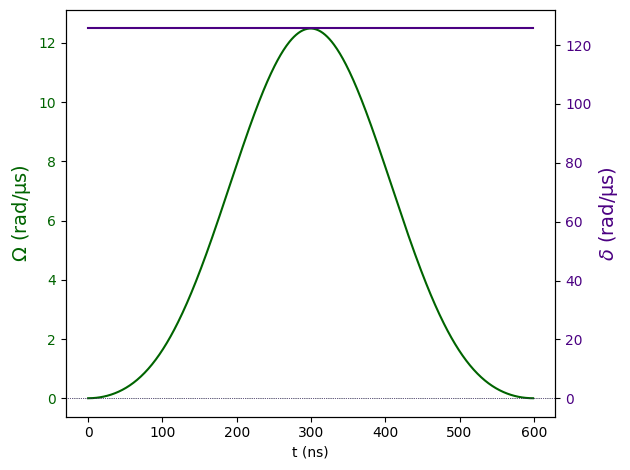

In [13]:
max_det_dmm = abs(dmm_seq.declared_channels["dmm_0"].bottom_detuning)
print("Max detuning the DMM can take:", max_det_dmm)
max_det_global = dmm_seq.declared_channels["rydberg_global"].max_abs_detuning
print("Max detuning the Rydberg.Global channel can take:", max_det_global)
det = min(max_det_dmm, max_det_global)
print("Detuning is taken as constant, equal to:", det)
pi_detuned_pulse = pulser.Pulse.ConstantDetuning(pi_wvf, det, 0.0)
pi_detuned_pulse.draw()

Let's now add the `Pulse` defined above on the `Rydberg.Global` channel. This is done with the classical `Sequence.add`. However, adding a detuning waveform to the `DMM` is done by calling `add_dmm_detuning`, and providing a negative waveform (the condition becomes $\delta_{DMM}(t) = - \delta(t)$)

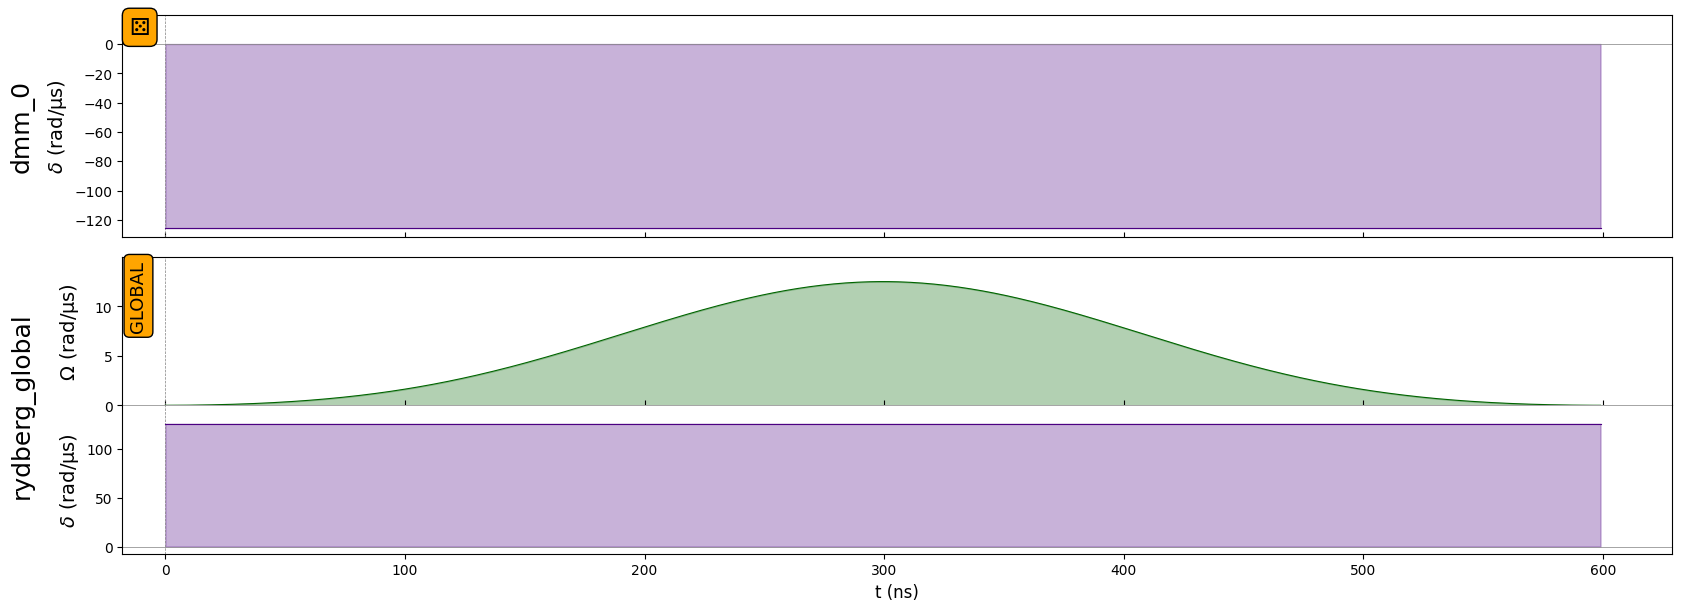

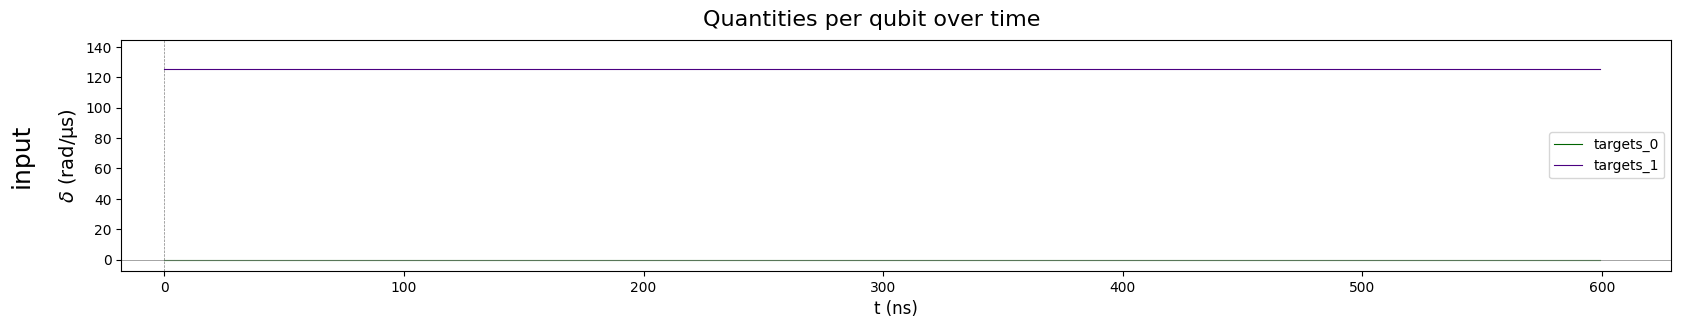

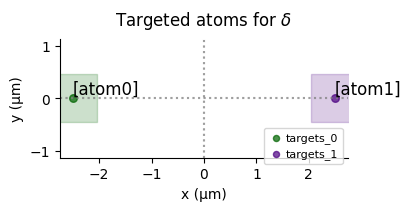

In [14]:
dmm_seq.add(pi_detuned_pulse, "rydberg_global")
dmm_seq.add_dmm_detuning(pulser.ConstantWaveform(600, -det), "dmm_0")
dmm_seq.draw(draw_qubit_det=True)

As we can see, the detuning applied on qubit `atom1` is very far from zero whereas `atom0` sees a perfect $\pi$-pulse. Let's see the effect on the final state:

In [15]:
sim = pulser_simulation.QutipBackend(dmm_seq)
res = sim.run()
res.get_final_state()

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 1.08934767e-05-2.99953051e-06j]
 [ 9.99446550e-01+0.00000000e+00j]
 [-2.03223039e-06+5.91242428e-05j]
 [ 3.31889280e-02+2.25510665e-03j]]

The final state is well the $\left|rg\right>$ state !
$$\left|rg\right> = (1, 0)\otimes(0, 1)=(0, 1, 0, 0)$$
We can see that the fidelity of the preparation we got here is a bit worse compared with the one we got with `Rydberg.Local`. This is due to the fact that we applied light: even if far detuned, it still tries to drive `atom1` to the Rydberg state, opening the possibility to measure the final state in other states than $\left|rg\right>$.

State preparation can also be done automatically using the **SLM Mask**. You can find an advanced tutorial on State Preparation with SLM Mask [here](https://pulser.readthedocs.io/en/stable/tutorials/slm_mask.html).

### Applying a $\pi$-pulse on `atom1`

Let's now apply a $\pi$-pulse on `atom1`, to drive the state of the atom from the ground to the rydberg state. With the `DetuningMap` chosen for the state preparation of $\left| rg\right>$, this is actually easier.
Let's remember the Hamiltonian describing the evolution of the system:
$$H = \frac{\hbar \Omega(t)}{2} \sigma_1^x + \frac{\hbar}{2}(\delta(t)-|\delta_{DMM}(t)|) n_1 + \frac{\hbar \Omega(t)}{2} \sigma_2^x + \frac{\hbar \delta(t)}{2} n_2+ \frac{C_6}{R^6} n_1n_2 $$
Making a $\pi$-pulse on `atom1` (qubit 2) means we want to have $\delta(t)=0$. Again, we are going to have light on `atom_0`, but this is okay if we have $\left|\delta(t)-|\delta_{DMM}(t)|\right| \gg 0$. This condition becomes $|\delta_{DMM}(t)| \gg 0$.

Let's then add a $\pi$-pulse on `Rydberg.Global`, and apply a constant detuning on the `DMM`, whose value is the minimum detuning that can be applied (the detuning on the `DMM` being negative):

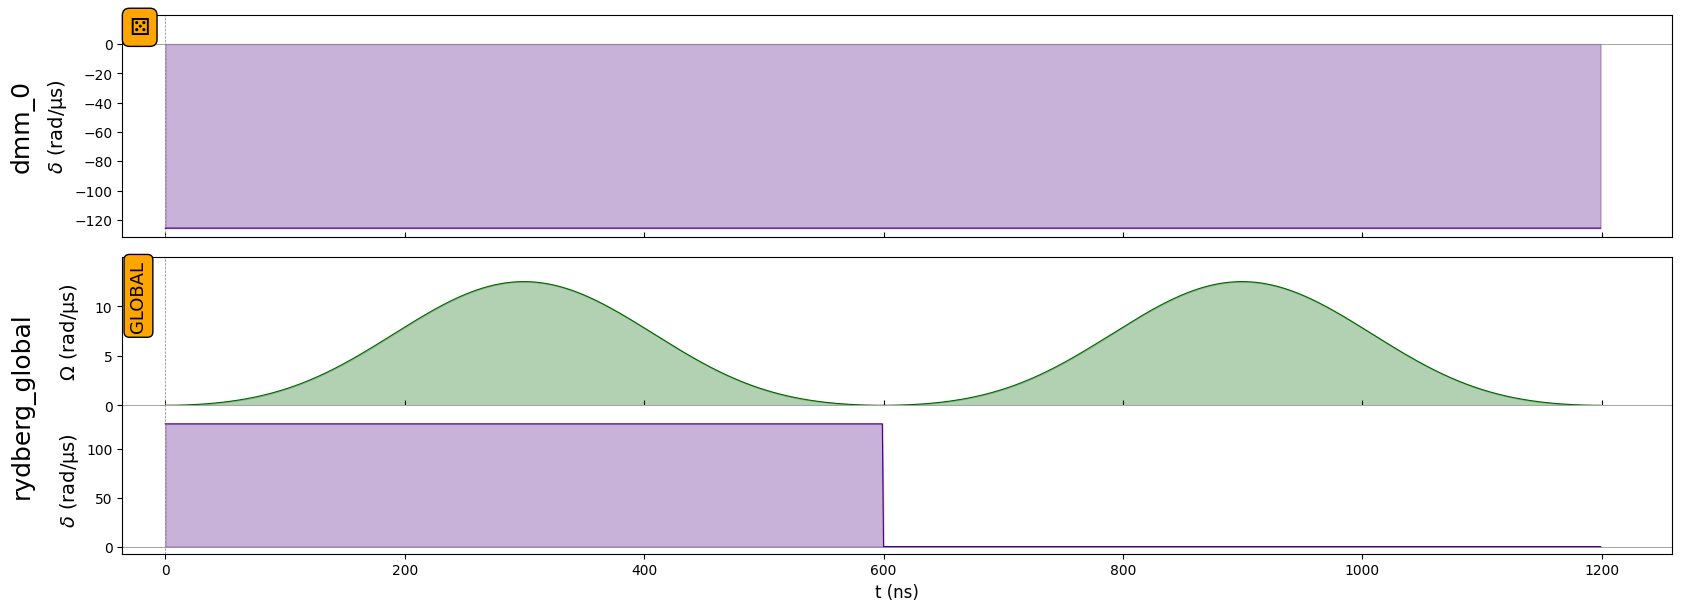

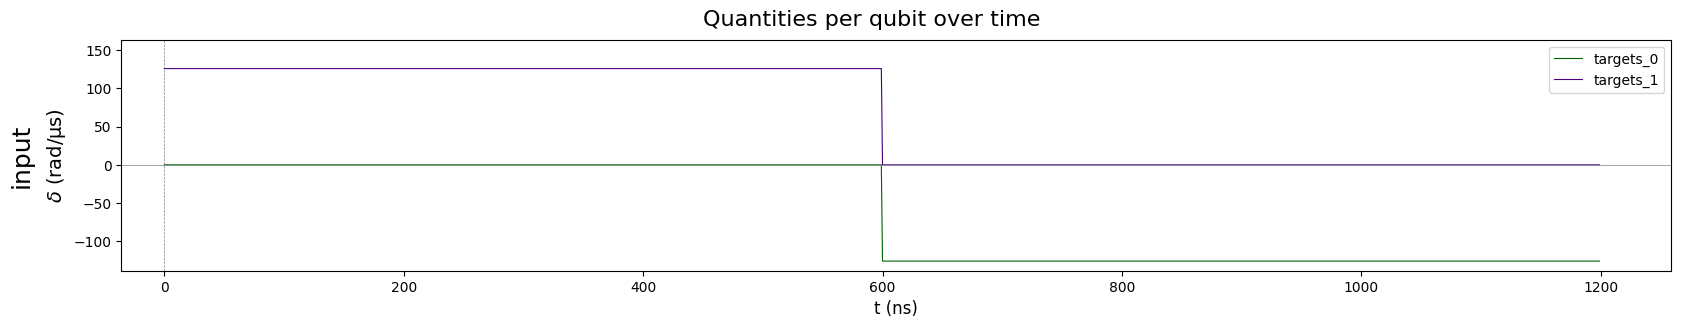

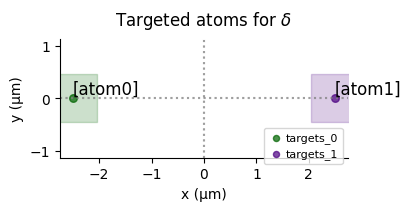

In [16]:
dmm_seq.add(pi_pulse, "rydberg_global")
dmm_seq.add_dmm_detuning(pulser.ConstantWaveform(600, -max_det_dmm), "dmm_0")
dmm_seq.draw(draw_qubit_det=True)

As we can see, the detuning applied on qubit `atom0` is very far below zero whereas `atom1` sees a perfect $\pi$-pulse. Let's see the effect on the final state:

In [17]:
sim = pulser_simulation.QutipBackend(dmm_seq)
res = sim.run()
res.get_final_state()

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 8.94347428e-06-6.29687086e-06j]
 [ 9.99444137e-01+0.00000000e+00j]
 [ 2.71814157e-03-3.32228330e-02j]
 [-2.69519722e-05+5.20453679e-04j]]

The final state is still the $\left|rg\right>$ state. We again demonstrate the Rydberg Blockade. Since we started with a mixture a state after the first state preparation, we can see the effect of the local $\pi$-pulse on `atom1` on the final state: the coefficient associated with $\left|gg\right>$ after the state preparation is now the component of the $\left|gr\right>$ state, and vice-versa.

This concludes this tutorial on local addressability, and the serie of two tutorials on the Rydberg Blockade. We could have used the techniques showed above to probe the Rydberg Blockade, and see the Rydberg Blockade Radius emerge. 

Local addressability is a necessity for **Digital-Analog Quantum Computing**. It is useful to solve Quantum Optimization problems like MWIS or to perform Quantum Machine Learning.

It can be used to program **Digital Quantum Gates** using `Rydberg` and `Raman` channels. That will be seen in the next tutorial.